In [1]:
import torch
from env import Box, get_last_states
from sampler import (
    BetaActionsSampler,
    MixtureOfBetasActionsSampler,
    TrajectoriesSampler,
)
from model import NeuralNet

import matplotlib.pyplot as plt
import numpy as np

/Users/salem/opt/miniconda3/envs/contgfn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
DIM = 2
DELTA = 0.1
COS = True
N_COMPONENTS = 1
SF_BIAS = 0.0
EPSILON = 0.0
PB = "tied"

BATCH_SIZE = 128
LR = 1e-3
LR_Z = 1e-1

if N_COMPONENTS == 1:
    output_dim = 1 + 2 * DIM
else:
    output_dim = 1 + N_COMPONENTS * (2 * DIM + 1)



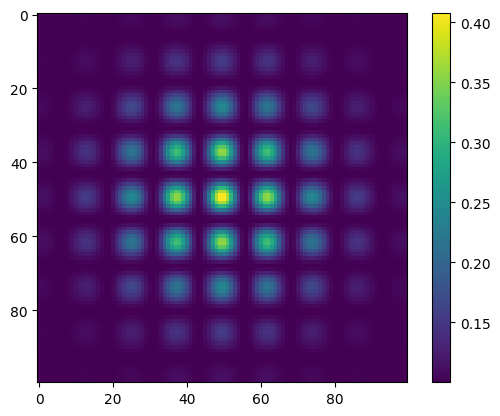

In [10]:
env = Box(dim=DIM, delta=DELTA, device_str="cpu", reward_cos=COS)

# Vizualize the environment
n = 100
x = torch.linspace(0, 1, n)
y = torch.linspace(0, 1, n)
xx, yy = torch.meshgrid(x, y)
grid_states = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

rewards  = env.reward(grid_states)
plt.imshow(rewards.reshape(n, n))
plt.colorbar()
plt.show()

In [11]:
model = NeuralNet(dim=DIM, hidden_dim=128, n_hidden=2, output_dim=output_dim)
bw_model = NeuralNet(dim=DIM, hidden_dim=128, n_hidden=2, output_dim=output_dim)
if PB == "tied":
    bw_model.torso = model.torso

if N_COMPONENTS == 1:
    actions_sampler = BetaActionsSampler(
        env, model, sf_bias=SF_BIAS, epsilon_uniform=EPSILON
    )
else:
    actions_sampler = MixtureOfBetasActionsSampler(
        env,
        model,
        n_components=N_COMPONENTS,
        sf_bias=SF_BIAS,
        epsilon_uniform=EPSILON,
    )

trajectories_sampler = TrajectoriesSampler(env, actions_sampler)


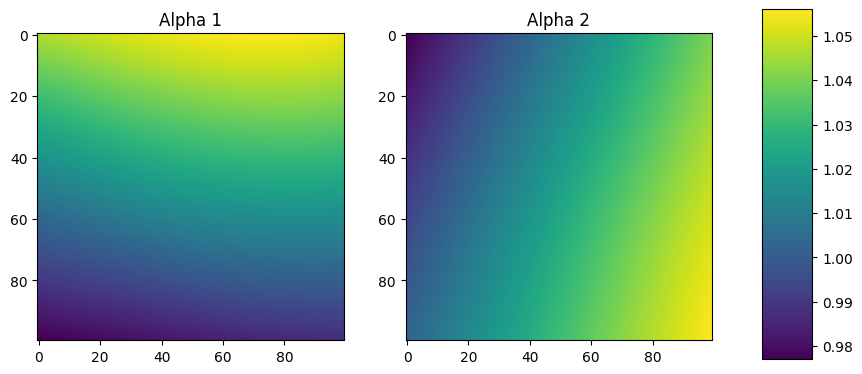

In [16]:
out = model(grid_states)
log_alphas = out[:, 1:3]
log_betas = out[:, 3:5]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.imshow(torch.exp(log_alphas[:, 0]).detach().reshape(n, n))
ax.set_title("Alpha 1")
ax = fig.add_subplot(122)
ax.imshow(torch.exp(log_alphas[:, 1]).detach().reshape(n, n))
ax.set_title("Alpha 2")
# colorbar for the two subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax.get_images()[0], cax=cbar_ax)
plt.show()


# plt.imshow(torch.sigmoid(out[:, 0] - 2).detach().reshape(n, n))
# plt.colorbar()
# plt.title("Probability of terminating")
# plt.show()
